In [13]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense, LSTM
from keras.initializers import RandomNormal
from keras.models import Sequential

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss
from simulator import simulate_ar_series

In [14]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 3070


In [16]:
r_0 = 0

rho_dist_0 = lambda : random.uniform(-1, 1)
v_dist_0 = lambda: random.uniform(0, 0.006)

# rho_dist_1 = lambda : np.random.beta(4, 4) * 2 - 1
rho_dist_1 = lambda : random.uniform(-1, 0) 
# v_dist_1 = lambda: 0.006 * np.random.beta(2, 10)
v_dist_1 = lambda: random.uniform(0, 0.006)

# rho_dist_2 = lambda : np.random.beta(3, 6) * 2 - 1
rho_dist_2 = lambda : random.uniform(0, 1)
# v_dist_2 = lambda: 0.006 * np.random.beta(5, 1)
v_dist_2 = lambda: random.uniform(0, 0.006)



ar_models = [
    lambda s : [simulate_ar_series(r_0, rho_dist_0, v_dist_0, n=100, fixed=False) for _ in range(s)],
    lambda s : [simulate_ar_series(r_0, rho_dist_1, v_dist_1, n=100, fixed=False) for _ in range(s)],
    lambda s : [simulate_ar_series(r_0, rho_dist_2, v_dist_2, n=100, fixed=False) for _ in range(s)]
]


In [17]:
x = np.array(ar_models[1](4))

print(x.shape)


(4, 100, 1)


In [18]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = LSTM(128, return_sequences=True)
        self.intermediate_network = LSTM(128, return_sequences=False)
        self.classification_network = Sequential([
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
        ])

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x = self.intermediate_network(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [19]:
# Data Preparation

BATCH_SIZE = 144
TRAIN_BATCHES = 144
VAL_BATCHES = 8
EPOCHS = 10

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulators=ar_models,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulators=ar_models,
    batch_size=BATCH_SIZE,
)

In [20]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(len(ar_models))

model.compile(
    optimizer=optimizer,
    loss=multimodel_exponential_loss,
    metrics=[multimodel_accuracy]
)

In [21]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - loss: 2.9984 - multimodel_accuracy: 0.3979 - val_loss: 2.9532 - val_multimodel_accuracy: 0.5660
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - loss: 2.3130 - multimodel_accuracy: 0.6559 - val_loss: 2.0026 - val_multimodel_accuracy: 0.6701
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - loss: 1.9485 - multimodel_accuracy: 0.6742 - val_loss: 1.9185 - val_multimodel_accuracy: 0.6719
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - loss: 1.8993 - multimodel_accuracy: 0.6774 - val_loss: 1.8789 - val_multimodel_accuracy: 0.6823
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - loss: 1.8560 - multimodel_accuracy: 0.6813 - val_loss: 1.8410 - val_multimodel_accuracy: 0.6788
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - loss: 1.8056 - multimodel_accuracy: 0.6785 - val_loss: 1.7761 - val_multimodel_accuracy: 0.6727
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - loss: 1.7646 - multimodel

In [22]:
num_models = len(ar_models)
cm = np.zeros((num_models, num_models), dtype=int)

# Fill confusion matrix
for idx, func in enumerate(ar_models):
    X_test = np.array(func(100))
    y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)

    f_x = model.predict(X_test[:, :], verbose=0)

    y_pred = np.argmax(f_x, axis=1)

    for true_label, pred_label in zip(y_test.flatten(), y_pred):
        cm[true_label, pred_label] += 1

    acc = np.mean(y_pred == y_test.flatten())
    print(f"Model {idx} accuracy: {acc*100:.2f}%")

# Pretty print confusion matrix
print("\nConfusion Matrix:")
header = "Predicted ->\t" + "\t".join([f"{i}" for i in range(num_models)])
print(header)
for i in range(num_models):
    row = "\t".join([str(cm[i, j]) for j in range(num_models)])
    print(f"True {i}:     \t{row}")

Model 0 accuracy: 0.00%
Model 1 accuracy: 100.00%
Model 2 accuracy: 0.00%

Confusion Matrix:
Predicted ->	0	1	2
True 0:     	0	100	0
True 1:     	0	100	0
True 2:     	0	100	0



Loss History


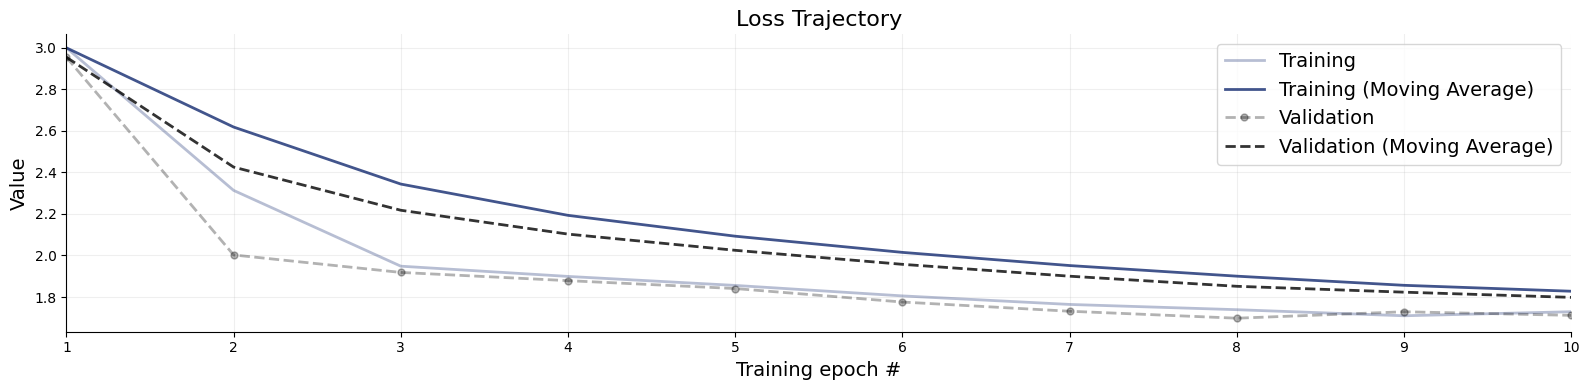

In [23]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()